In [1]:
# ライブラリの読み込み
using Optim # 最適化関数（カリブレーションに使用）
using Plots # グラフのプロット

In [2]:
struct Model{TI<:Integer, TF<:AbstractFloat}
    rstar::TF   # pH=0のときの、定常状態での名目金利の値
    bet::TF     # 割引率
    phi::TF     # テイラー係数
    kap::TF     # フィリップス曲線の傾き
    sH::TF      # 状態Hでの自然利子率の値
    sL::TF      # 状態Lでの自然利子率の値
    pH::TF      # 危機が起こる確率
    pL::TF      # 危機の継続確率
    maxiter::TI # 繰り返し回数の最大値
    tol::TF     # 許容誤差
end

In [3]:
function dist(x0,sH,pH,pL,bet,phi,rstar,yLtar,piLtar)
    """
    ----------------------------------------------------------------
    === 所与のパラメータから得られるモデルの値とターゲット値との距離 ===
    ----------------------------------------------------------------
    ※カリブレーションで用いる関数
    ※調整するパラメータ:{sL,kap}
    ※ターゲット:{yL,piL}
    <input>
    ・x0: [sL,kap]を含むベクトル(調整するパラメータ)
    ・sH: 状態Hでの自然利子率の値
    ・pH: 危機が起こる確率
    ・pL: 危機の継続確率
    ・bet: 割引率
    ・phi: テイラー係数
    ・rstar: pH=0のときの、定常状態での名目金利の値
    ・yLtar: 状態Lでの生産ギャップのターゲット
    ・piLtar: 状態Lでのインフレ率のターゲット
    <output>
    ・f: 所与のパラメータから得られるモデルの値とターゲット値との距離(の二乗和)
    """
    # 最適化問題を解くために引数をベクトルにする必要がある。
    sL = x0[1]
    kap = x0[2]

    # 解析的解({yH,yL,piH,piL}についての連立方程式を解くことで解を求める)
    # Ax = b を解く。x=[yH;yL;piH;piL] である。 
    # A:係数行列
    A = [-1+(1-pH) pH -(phi-1)*(1-pH) -(phi-1)*pH;
    (1-pL) -1+pL (1-pL) pL;
    kap 0 -1+bet*(1-pH) bet*pH;
    0 kap bet*(1-pL) -1+bet*pL]
    # b: 定数項のベクトル
    b = [rstar-sH;-sL;0;0] 
    x = A\b

    yL = x[2]
    piL = x[4]

    # データの値とモデルの値の間の距離を求める
    f = (yL-yLtar)^2 + (piL-piLtar)^2

    return f

end

dist (generic function with 1 method)

In [4]:
function ti(m)
    """
    ---------------------------------------
    === 時間反復法によってモデルを解く関数 ===
    ---------------------------------------
    <input>
    ・m: パラメータを含むコンストラクタ
    <output>
    ・yvec0: 均衡での生産ギャップ
    ・pvec0: 均衡でのインフレ率
    ・rvec0: 均衡での名目金利
    """

    # STEP 1(a): グリッド生成
    Gs = [m.sH; m.sL];  # 外生的ショック
    Ps = [1-m.pH m.pH;
          1-m.pL m.pL]; # ショックの遷移行列
    
    # STEP 1(b): 政策関数の初期値を当て推量
    Ns = 2;
    # 適当な初期値
    yvec0 = zeros(Ns)
    pvec0 = zeros(Ns)
    rvec0 = zeros(Ns)
    yvec1 = zeros(Ns)
    pvec1 = zeros(Ns)
    rvec1 = zeros(Ns)

    # STEP 4: 政策関数を繰り返し計算
    diff = 1e+4 # 政策関数の繰り返し誤差
    iter = 1 # ループ・カウンター
    
    while diff > m.tol

        for is in 1:Ns

            # ショックの値
            s0 = Gs[is];

            # 古い政策関数から期待値(ye,pie)を計算
            ye = Ps[is,:]' * yvec0;
            pie = Ps[is,:]' * pvec0;

            # 期待値を所与として最適化
            r0 = max(m.rstar + m.phi*pie, 0.0);
            y0 = ye - (r0 - pie - s0);
            p0 = m.kap*y0 + m.bet*pie;

            # 新しい政策関数を保存
            yvec1[is] = y0;
            pvec1[is] = p0;
            rvec1[is] = r0;
            
        end

        # 繰り返し計算誤差を確認
        ydiff = maximum(abs.(yvec1-yvec0))
        pdiff = maximum(abs.(pvec1-pvec0))
        rdiff = maximum(abs.(rvec1-rvec0))
        diff = maximum([ydiff pdiff rdiff])

        #println([iter diff])

        # 政策関数をアップロード
        # 注意：Juliaで配列の代入はポインタ渡し
        yvec0 = copy(yvec1)
        pvec0 = copy(pvec1)
        rvec0 = copy(rvec1)

        iter += 1
        
    end

    return yvec0, pvec0, rvec0
end

ti (generic function with 1 method)

In [5]:
rstar = 0.75; # pH=0のときの、定常状態での名目金利の値
bet = 1/(1+rstar/100); # 割引率(オイラー方程式の定常状態より)
phi = 5.0;  # テイラー係数(注: 小さいとiL=0にならない)
pL = 0.75;  # 危機の継続確率
sH = rstar; # 状態Hでの自然利子率の値

# カリブレーション
# yLとpiLのターゲットにpH=0のときのモデルの値を合わせるように、sLとkapの値をセット

pH = 0.0; # 危機が起こる確率
x0 = [-2.0, 0.01]; # sLとkapの初期値

# yLとpiLのターゲット
yLtar = -7.0
piLtar = -1.0/4

# 最小化関数(Juliaの場合NelderMead()を用いる)
res = optimize(x->dist(x,sH,pH,pL,bet,phi,rstar,yLtar,piLtar),x0,NelderMead());

# カリブレートしたパラメータをセット
sL = res.minimizer[1];  # 状態Lでの自然利子率の値
kap = res.minimizer[2]; # フィリップス曲線の傾き

maxiter = 2000; # 繰り返し回数の最大値
tol = 1e-5; # 許容誤差

In [6]:
# pH=0.0 のケースで数値解を計算する
pH = 0.0
# 構造体にパラメータを格納
m = Model(rstar,bet,phi,kap,sH,sL,pH,pL,maxiter,tol)
@time yvec0, pvec0, rvec0 = ti(m);

  0.268820 seconds (727.46 k allocations: 39.415 MiB, 4.69% gc time, 99.89% compilation time)


In [7]:
# pH=0.025 のケースで数値解を計算する
pH = 0.025
# 構造体にパラメータを格納
m = Model(rstar,bet,phi,kap,sH,sL,pH,pL,maxiter,tol)
@time yvec1, pvec1, rvec1 = ti(m);

  0.000697 seconds (18.39 k allocations: 1.402 MiB)


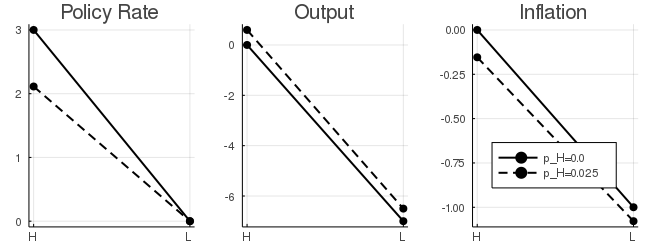

In [8]:
x1 = [1 2; 1 2]
x2 = x1
x3 = x1
y1 = [rvec0'*4; rvec1'*4]
y2 = [yvec0'; yvec1']
y3 = [pvec0'*4; pvec1'*4]
cl = [:black :black]
ls = [:solid :dash]

p1 = plot(x1',y1',title="Policy Rate",color=cl,linestyle=ls,legend=false)
p2 = plot(x2',y2',title="Output",color=cl,linestyle=ls,legend=false)
p3 = plot(x3',y3',title="Inflation",color=cl,linestyle=ls,legend=:bottomleft,label=["p_H=0.0" "p_H=0.025"])

plot(p1,p2,p3,layout=(1,3),size=(650,250),linewidth=2,markershape=:circle,markersize=4,xticks=([1 2],["H" "L"]))